# Newton Examples

This notebook is to study the behavior of the function to root-find with Newton.
We use this to motivate our design for the optimal optimizer.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyglstudy as gl

## Upper Bound via Taylor Expansion

One possible way to construct the upper bound is to form a second-order Taylor expansion of $\varphi$ 
around $0$ and solve for the smaller root (guaranteed to be positive).

In [3]:
def h_max_taylor(L, v, l1, l2):
    L = L + l2
    l1_2 = l1 * l1
    l1_3 = l1_2 * l1
    l1_4 = l1_3 * l1
    v_square = v ** 2
    v_square_L = v_square * L
    c = np.sum(v_square) / l1_2
    b = -2 * np.sum(v_square_L) / l1_3
    a = 3 * np.sum(v_square_L * L) / l1_4
    discr = np.maximum(b * b - 4 * a * c, 0) 
    return np.maximum(-b - np.sqrt(discr) / (2 * a), 0)

In [4]:
np.random.seed(0)
x = np.linspace(0, 10, 100)
p = 1000
L = np.concatenate(
    [np.zeros(int(p*0.2)), np.random.uniform(1e-14, 1e-8, int(p*0.1)), np.random.uniform(0.8, 2, p)],
)
v = np.random.normal(0, 1, len(L)) * np.sqrt(L)
l1 = 1e-4
l2 = 0

(
    gl.compute_h_max(L+l2, v, l1, 1e-10)['h_max'],
    h_max_taylor(L, v, l1, l2), 
    np.linalg.norm(gl.newton_abs_solver(L, v, l1, l2, 1e-10, 1000)['beta'])
)

TypeError: compute_h_max(): incompatible function arguments. The following argument types are supported:
    1. (arg0: numpy.ndarray[numpy.float64[m, 1], flags.writeable], arg1: numpy.ndarray[numpy.float64[m, 1], flags.writeable], arg2: float) -> dict

Invoked with: array([0.        , 0.        , 0.        , ..., 1.9604659 , 1.53806962,
       1.46292687]), array([ 0.        , -0.        ,  0.        , ...,  0.74185545,
       -0.91699018, -0.45472927]), 0.0001, 1e-10

Current $h_{\max}$ computation is much closer to the truth than the Taylor approximation.
This is because our current method has a closer curvature in the tail region than the Taylor approximation.
A quadratic is really bad for approximating the tail when our function looks like $f(x) = x^{-2}$.

## When is Newton really slow?

In [5]:
def phi(x, L, v, l1, l2):
    return gl.block_norm_objective(x, L+l2, v, l1)
    
vphi = np.vectorize(phi, excluded=[1,2,3,4])

In [6]:
def assess(L, v, l1, l2, tol=1e-8, max_iters=int(1000)):
    smart_out = gl.newton_solver_debug(
        L, v, l1, l2, tol, max_iters, True,
    )
    naive_out = gl.newton_solver_debug(
        L, v, l1, l2, tol, max_iters, False,
    )
    outs = [smart_out, naive_out]
    titles = ['Newton-ABS', 'Newton']

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, layout='compressed') 
    
    for i, ax in enumerate(axes):
        out_nsd = outs[i]
        iters = out_nsd['iters']
        smart_iters = out_nsd['smart_iters']
        beta = out_nsd['beta']

        if np.all(beta == 0):
            print("True solution is 0. Nothing to show.")
            return

        h = np.linalg.norm(beta)
        fh = phi(h, L, v, l1, l2)

        xs = np.linspace(0, h * 1.05, 5000)
        f_xs = vphi(xs, L, v, l1, l2)

        ax.plot(xs, f_xs, linestyle='--', label='$\\varphi$')
        ax.scatter(h, fh, marker='*', color='red', s=50, label='Solution')

        if len(iters) > 0:
            f_iters = vphi(iters, L, v, l1, l2)
            ax.scatter(iters, f_iters, color='blue', s=50, marker='.', alpha=0.7, label="Newton")
    
        if len(smart_iters) > 0:
            f_smart_iters = vphi(smart_iters, L, v, l1, l2)
            ax.scatter(smart_iters, f_smart_iters, color='orange', s=70, marker='v', alpha=0.7, label='ABS')
            
        ax.set_title(titles[i])
        ax.set_xlabel("$\\|\\beta\\|$")
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    fig.legend(labels=['$\\varphi$', 'Solution', 'Newton', 'ABS'])
    fig.supylabel("$\\varphi$")
    plt.show()
    
    return {
        'smart': smart_out,
        'naive': naive_out,
        'plot' : (fig, axes),
    }

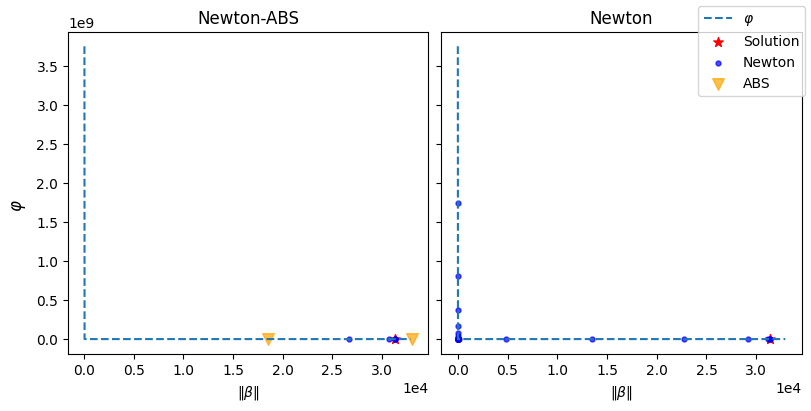

In [7]:
np.random.seed(0)
p = 100
L, v = gl.data.generate_block_norm_data(p, 0.2, 0.1)
l1 = 1e-4
l2 = 0
data_out = assess(L, v, l1, l2)
data_out['plot'][0].savefig('figures/newton_stuck.pdf', bbox_inches='tight')